# Hyperparameter Tuning "From Scratch"
Here, we are tuning hyperparameters for a Random Forest Classifier. Since we're using a Gaussian Process surrogate model, the hyperparameters - **n_estimators** (the number of trees in the forest) and **max_depth** (of each decision tree) - are treated as continuous variables during optimization.

Increasing the number of trees generally improves accuracy on unseen data and reduces variance (i.e., overfitting), but only up to a point. Too many trees can increase training time and memory usage without significant gains in accuracy. 

Deeper trees can model more complex patterns and may overfit, while shallower trees are faster to evaluate but may underfit. 

I chose 2 hyperparameters because it's much easier to visualize for the Bayesian optimization portion.

In [1]:
import numpy as np
import pandas as pd
import openml
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

from sklearn.ensemble import RandomForestClassifier
# from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, make_scorer

We use the raw OpenML credit-g dataset, which contains 1000 samples with 20 features, classifying people as good or bad credit risks. In this context, false positives (predicting good credit when it's actually bad) are more costly.

Feature scaling is important when features have different units or scales, and is essential for algorithms that rely on distance calculations or gradients, but not needed for tree-based models like random forests, which can handle mixed feature scales and types by splitting based on feature thresholds. 


In [9]:
seed = 36
dataset_id = 31
dataset = openml.datasets.get_dataset(dataset_id)
df, *_ = dataset.get_data()
df

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,...,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker,class
0,<0,6,critical/other existing credit,radio/tv,1169.0,no known savings,>=7,4,male single,none,...,real estate,67,none,own,2,skilled,1,yes,yes,good
1,0<=X<200,48,existing paid,radio/tv,5951.0,<100,1<=X<4,2,female div/dep/mar,none,...,real estate,22,none,own,1,skilled,1,none,yes,bad
2,no checking,12,critical/other existing credit,education,2096.0,<100,4<=X<7,2,male single,none,...,real estate,49,none,own,1,unskilled resident,2,none,yes,good
3,<0,42,existing paid,furniture/equipment,7882.0,<100,4<=X<7,2,male single,guarantor,...,life insurance,45,none,for free,1,skilled,2,none,yes,good
4,<0,24,delayed previously,new car,4870.0,<100,1<=X<4,3,male single,none,...,no known property,53,none,for free,2,skilled,2,none,yes,bad
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,no checking,12,existing paid,furniture/equipment,1736.0,<100,4<=X<7,3,female div/dep/mar,none,...,real estate,31,none,own,1,unskilled resident,1,none,yes,good
996,<0,30,existing paid,used car,3857.0,<100,1<=X<4,4,male div/sep,none,...,life insurance,40,none,own,1,high qualif/self emp/mgmt,1,yes,yes,good
997,no checking,12,existing paid,radio/tv,804.0,<100,>=7,4,male single,none,...,car,38,none,own,1,skilled,1,none,yes,good
998,<0,45,existing paid,radio/tv,1845.0,<100,1<=X<4,4,male single,none,...,no known property,23,none,for free,1,skilled,1,yes,yes,bad


In [10]:
cat_columns = df.select_dtypes(['category']).columns
print(cat_columns) # this prints the "names" of each column
cat_mappings = {}
for col in cat_columns:
    # enumerate gives each category a number
    # I think the numbers matches cat.codes' because cat.categories and cat.codes are aligned,
    # cat.codes gives a number corresponding to the position of each value in cat.categories
    cat_mappings[col] = dict(enumerate(df[col].cat.categories)) 
print(cat_mappings) # a dictionary of dictionaries

# Change categorical labels to code values
df[cat_columns] = df[cat_columns].apply(lambda x: x.cat.codes)

# X has a mix of categorical and numerical values
X = df.drop(columns='class').values 
y = df['class'].values
print(X.shape) # (1000, 20)
print(y.shape) # (1000, )

# 80% of data for training, 20% for testing, shuffled
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)
print(X_train, X_train.shape) # (800, 20)
print(X_test, X_test.shape) # (200, 20)
print(y_train, y_train.shape) # (800, ), should be binary
print(y_test, y_test.shape) # (200, ), should be binary

Index(['checking_status', 'credit_history', 'purpose', 'savings_status',
       'employment', 'personal_status', 'other_parties', 'property_magnitude',
       'other_payment_plans', 'housing', 'job', 'own_telephone',
       'foreign_worker', 'class'],
      dtype='object')
{'checking_status': {0: '<0', 1: '0<=X<200', 2: '>=200', 3: 'no checking'}, 'credit_history': {0: 'no credits/all paid', 1: 'all paid', 2: 'existing paid', 3: 'delayed previously', 4: 'critical/other existing credit'}, 'purpose': {0: 'new car', 1: 'used car', 2: 'furniture/equipment', 3: 'radio/tv', 4: 'domestic appliance', 5: 'repairs', 6: 'education', 7: 'vacation', 8: 'retraining', 9: 'business', 10: 'other'}, 'savings_status': {0: '<100', 1: '100<=X<500', 2: '500<=X<1000', 3: '>=1000', 4: 'no known savings'}, 'employment': {0: 'unemployed', 1: '<1', 2: '1<=X<4', 3: '4<=X<7', 4: '>=7'}, 'personal_status': {0: 'male div/sep', 1: 'female div/dep/mar', 2: 'male single', 3: 'male mar/wid', 4: 'female single'}, 'other_

## Training an RF Classifier 
At this point, we're not performing any hyperparameter tuning.

We observe that the current model incorrectly classifies 28 "bad" samples as "good", which accounts for about half of the actual "bad" group in the training data. Let's see if hyperparameter tuning can improve this performance.

Accuracy (default):  0.805
29 28 11 132
Custom Score:  0.47
High-ish number of false positives (depends on seed)


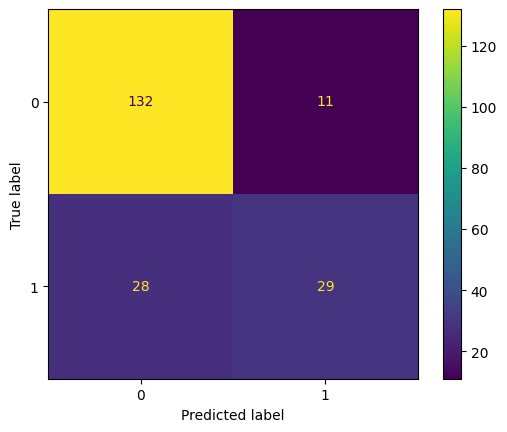

In [21]:
# This custom score penalizes false positives
def custom_score(y_true, y_pred):
    # We put '1' first in labels because it represents 'bad' - more intuitive that way
    cm = confusion_matrix(y_true, y_pred, labels=[1, 0])
    tn, fp, fn, tp = cm.ravel()
    total = tn + fp + fn + tp 
    # True positive + true negative - 2*false positive - false negative
    weighted_score = tp + tn - 2 * fp - fn
    return weighted_score / total


classifier = RandomForestClassifier(n_estimators=100, max_depth=20, random_state=seed)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test) # predictions on test set

# Evaluate classifier accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy (default): ", accuracy) # about 74%
        
# Confusion matrix
# 0 is good, 1 is bad (sort of reversed, but it's okay)
c_matrix = confusion_matrix(y_test, y_pred, labels=[1,0])
tn, fp, fn, tp = c_matrix.ravel()
print(tn, fp, fn, tp)
print("Custom Score: ", custom_score(y_test, y_pred))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
print("High-ish number of false positives (depends on seed)")


## Hyperparameter Tuning
Now we'll use Bayesian Optimization with a Gaussian Process surrogate model to tune the hyperparameters of the Random Forest. 

We are trying to approximate the following function to predict which set of hyperparameters performs best:
    $$f(θ)=\text{CV score of model with hyperparameters } θ$$
where:
- $\theta$ = a set of hyperparameters (n_estimators, max_depth)
- $f(\theta)$ = the model's performance (accuracy, F-1, etc.)

Our implementation of BO+GP uses:
- an RBF kernel for the GP,
- a UCB acquisition function, which we maximize (unlike scikit-optimize's gp_minimize, which minimizes),
- and a prior distribution with a mean of 0 for all inputs. 


In [22]:
# We're trying to MAXIMIZE this objective function
def objective(X):
    """
    X: an array of [n_estimators, max_depth] inputs

    returns an array of scores for each input (n, 1)
    """
    scores = []
    for param in X: # iterate through each input
        model = RandomForestClassifier(n_estimators=int(param[0]), max_depth=int(param[1]), random_state=seed)
        # No need to invert, already maximizing - higher accuracy value is better 
        score = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy').mean() 
        # print(score)
        scores.append(score)
    return np.array(scores).reshape(-1,1)
    
# This objective function penalizes false positives more, uses the custom_score defined above
# make_scorer wraps custom_score into a callable object compatible with sklearn
custom_scorer = make_scorer(custom_score, greater_is_better=True)
def objective_weighted(X):
    scores = []
    for param in X:
        model = RandomForestClassifier(n_estimators=int(param[0]), max_depth=int(param[1]), random_state=seed)
        score = cross_val_score(model, X_train, y_train, cv=5, scoring=custom_scorer).mean()
        scores.append(score)
    return np.array(scores).reshape(-1,1)

def squared_euclidean_distance(xa, xb):
     # ||a - b||^2 = ||a||^2 + ||b||^2 - 2a⋅b
    # Reduce (n,d) to (n,1), (m,d) to (1,m)
    xa2 = np.sum(xa**2, axis=1).reshape(-1, 1)   # shape: (n,1)
    xb2 = np.sum(xb**2, axis=1).reshape(1, -1)   # shape: (1,m)

    # print("xa2:", xa2)
    # print("xb2:", xb2)

    # Compute pairwise dot products
    dot_prod = np.dot(xa, xb.T)                  # shape: (n,m)

    # Apply the distance formula
    return xa2 + xb2 - 2 * dot_prod              # shape: (n,m)


def rbf_kernel(xa, xb, sigma=1):
    sqdist = squared_euclidean_distance(xa, xb)
    return np.exp(-0.5 * 1/(sigma**2) * sqdist)

# This should work with inputs of any number of dimensions
def GP(X1, y1, X2, sigma=1.0, noise=0):
    """
    Compute the posterior mean and covariance of a Gaussian Process with RBF Kernel. 

    Parameters:
    - X1: (n,d) array of n d-dimensional training inputs
    - y1: (n,1) array of n training outputs
    - X2: (m,d) array of m d-dimensional test inputs (where we want to predict)
    - sigma: RBF kernel parameter (length scale)
    - noise: for modeling noise (standard deviation, not variance) 

    Returns:
    - mu: (m,1) posterior mean or m predicted values for X2
    - cov: (m,m) posterior covariance matrix for X2
    """
    # In case 1D array passed
    y1 = y1.reshape(-1, 1)
    
    # Kernel (covariance) matrices
    # Add noise on diagonal for K11
    K11 = rbf_kernel(X1, X1, sigma) + (noise**2) * np.eye(len(X1)) + 1e-8 * np.eye(len(X1)) # shape: (n,n)
    K22 = rbf_kernel(X2, X2, sigma)                                # shape: (m,m)
    K12 = rbf_kernel(X1, X2, sigma)                                # shape: (n,m)

    # Invert K11
    K11_inv = np.linalg.inv(K11)

    # Posterior mean
    mu = K12.T @ K11_inv @ y1 # # @ is matrix multiplication

    # Posterior covariance
    cov = K22 - K12.T @ K11_inv @ K12

    # Regularize to ensure diagonal values are non-negative
    cov += 1e-6 * np.eye(cov.shape[0])

    return mu, cov


# Acquisition function: UCB
def acquisition_ucb(mu, std, beta=2.0):
    return mu + beta * std

# I'll work on making this more generalizable later
def bayesian_opt(objective, bounds, init_points=5, iterations=10, beta=2.0, sigma=1.0, noise=0):
    """
    objective: the objective function
    bounds: range of values for variable(s) within X [[min1, min2], [max1, max2]]
    init_points: size of initial training dataset
    beta: UCB acquisition parameter
    sigma: RBF kernel parameter
    noise: standard deviation, not variance
    """
    # Initial data (set of [n_estimators, max_depth] inputs)
    # This is not the data used to train the classifier, renamed to avoid duplicated variable names
    X_param_train = np.random.uniform(bounds[0], bounds[1], size=(init_points, len(bounds)))
    y_param_train = objective_weighted(X_param_train) # set of scores

    print("X_param_train: ", X_param_train)
    print("y_param_train: ", y_param_train)

    # Evaluation grid for plotting and acquisition
    # Make a grid of 100 points along each dimension
    x1 = np.linspace(bounds[0][0], bounds[1][0], 100)
    x2 = np.linspace(bounds[0][1], bounds[1][1], 100)
    # Make a grid of 2D points for prediction
    # meshgrid creates all combinations of x1 and x2 
    X1, X2 = np.meshgrid(x1, x2) 
    # each point is [x1, x2], or [n_estimators, max_depth]
    X_grid = np.vstack([X1.ravel(), X2.ravel()]).T # 10000 input points (10000, 2)
    print("X_grid: ", X_grid)
    
    mu = None
    cov = None
    std = None
    best_hyperparam = None
    best_cv_score = float('-inf')
    for i in range(iterations):
        print(f"Iteration {i}")
        # Update surrogate, get predictions for X_grid
        mu, cov = GP(X_param_train, y_param_train, X_grid, sigma, noise)
        print("Mean: ", mu)
        print("Covariance: ", cov)

        # Standard deviation for uncertainty 
        std = np.sqrt(np.diag(cov)).reshape(-1, 1)

        # Score each X_grid input
        scores = acquisition_ucb(mu, std)
        print("Scores: ", scores)
        print("Scores shape: ", scores.shape)

        # Choose next point from X_grid
        next_x = np.array([X_grid[np.argmax(scores)]]) # maximize acquisition function
        print("Next x: ", next_x)
        next_y = objective_weighted(next_x)
        print("Next y: ", next_y)

        if next_y[0,0] > best_cv_score:
            best_cv_score = next_y[0,0]
            best_hyperparam = next_x

        # Append to training data
        X_param_train = np.vstack((X_param_train, next_x.reshape(1, -1)))
        y_param_train = np.vstack((y_param_train, next_y.reshape(1, -1)))

    # Plot time
    mu_grid = mu.reshape(100, 100)
    std_grid = std.reshape(100, 100)
    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_surface(X1, X2, mu_grid, cmap=cm.viridis, linewidth=0, antialiased=False, alpha=0.9)
    ax.scatter(X_param_train[:, 0], X_param_train[:, 1], y_param_train.flatten(), c='red', label='Training Points')
    ax.set_xlabel('n_estimators')
    ax.set_ylabel('max_depth')
    ax.set_zlabel('Predicted Accuracy')
    ax.set_title('GP Posterior Mean')
    fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)
    plt.grid(True)
    plt.legend()
    plt.show()
    return best_hyperparam

X_param_train:  [[168.39638877 115.62763826]
 [116.30647218  93.06013414]
 [114.40431139 179.17988398]
 [161.45389529  42.87142475]
 [ 36.39947482  31.08249356]]
y_param_train:  [[0.3075 ]
 [0.31875]
 [0.31125]
 [0.33   ]
 [0.27625]]
X_grid's shape:  (10000, 2)
X_grid:  [[ 10.          10.        ]
 [ 11.91919192  10.        ]
 [ 13.83838384  10.        ]
 ...
 [196.16161616 200.        ]
 [198.08080808 200.        ]
 [200.         200.        ]]
GP Mean:  [[3.87806518e-249]
 [6.20316313e-228]
 [2.49445381e-208]
 ...
 [0.00000000e+000]
 [0.00000000e+000]
 [0.00000000e+000]]
GP Mean (grid):  [[3.87806518e-249 6.20316313e-228 2.49445381e-208 ... 0.00000000e+000
  0.00000000e+000 0.00000000e+000]
 [2.29582499e-232 3.67228922e-211 1.47672335e-191 ... 0.00000000e+000
  0.00000000e+000 0.00000000e+000]
 [3.41685557e-217 5.46543482e-196 2.19779401e-176 ... 0.00000000e+000
  0.00000000e+000 0.00000000e+000]
 ...
 [0.00000000e+000 0.00000000e+000 0.00000000e+000 ... 0.00000000e+000
  0.00000000

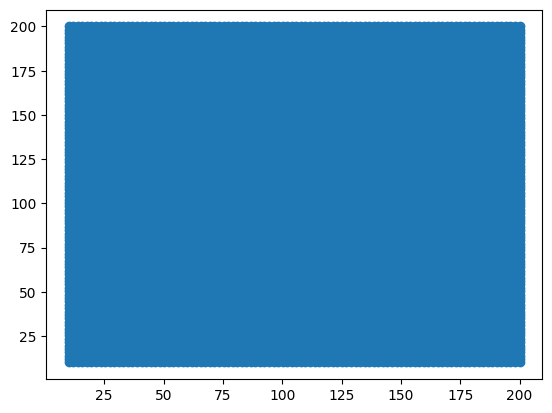

In [23]:
# Code testing
bounds = [[10,10], [200,200]] # x1 is [10, 200], x2 is [10, 200]
X_param_train = np.random.uniform(low=bounds[0], high=bounds[1], size=(5, len(bounds))) 
print("X_param_train: ", X_param_train) # (5 data points, 2 variables per data point - n_estimators and max_depth)

y_param_train = objective_weighted(X_param_train)
print("y_param_train: ", y_param_train) # (5 mean CV scores, )

# Make a grid of 100 points along each dimension
x1 = np.linspace(bounds[0][0], bounds[1][0], 100)
x2 = np.linspace(bounds[0][1], bounds[1][1], 100)

# Make a grid of 2D points for prediction
# meshgrid creates all combinations of x1 and x2 
X1, X2 = np.meshgrid(x1, x2) 
plt.scatter(X1, X2) # should be a grid
X_grid = np.vstack([X1.ravel(), X2.ravel()]).T # each point is a 2D points (x1, x2)
print("X_grid's shape: ", X_grid.shape) # (10000, 2)
print("X_grid: ", X_grid)

mu, cov = GP(X_param_train, y_param_train, X_grid)
print("GP Mean: ", mu)
mu_grid = mu.reshape(100, 100)
print("GP Mean (grid): ", mu_grid)
print(mu_grid.shape)

X_param_train:  [[123.80634814  58.09896028]
 [169.99393169  77.01908527]
 [152.54135135 191.49711256]
 [ 19.23240345 158.4352796 ]
 [ 81.27724569 183.0410731 ]
 [176.66136821  19.98924918]
 [162.00004182  64.5659169 ]
 [154.52952922  70.4688511 ]
 [ 87.73518934 177.80042974]
 [192.98314587  39.10433955]
 [ 27.87266702  67.44055365]
 [146.56894657 144.60558416]
 [ 85.22591466  71.79319587]
 [166.60357944 198.5771142 ]
 [ 23.93361249 145.59673404]
 [ 22.33528651  71.73731356]
 [ 33.33030408 169.96634378]
 [ 74.93974158  39.23300194]
 [ 69.03191295  39.90887724]
 [ 83.48576167  22.97884599]]
y_param_train:  [[0.325  ]
 [0.31875]
 [0.31875]
 [0.29875]
 [0.31875]
 [0.31125]
 [0.3275 ]
 [0.32   ]
 [0.32   ]
 [0.30625]
 [0.2825 ]
 [0.33375]
 [0.3175 ]
 [0.31125]
 [0.2725 ]
 [0.2775 ]
 [0.28625]
 [0.3275 ]
 [0.32   ]
 [0.32625]]
X_grid:  [[ 10.          10.        ]
 [ 11.91919192  10.        ]
 [ 13.83838384  10.        ]
 ...
 [196.16161616 200.        ]
 [198.08080808 200.        ]
 [200. 

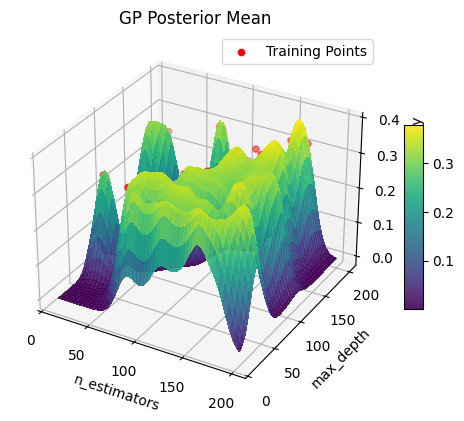

[[121.31313131 119.39393939]]


In [30]:
# We can experiment with different BO hyperparameters later 
result = bayesian_opt(objective, bounds, init_points=20, iterations=30, sigma=10) 
print(result)

Accuracy:  0.81
[[131  12]
 [ 26  31]]


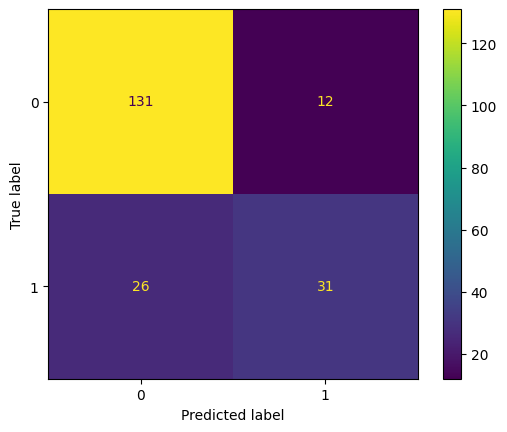

In [31]:
result = result.flatten()
classifier = RandomForestClassifier(n_estimators=int(result[0]), max_depth=int(result[1]), random_state=seed)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test) # predictions on test set

# Evaluate classifier accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: ", accuracy)

# Confusion matrix
c_matrix = confusion_matrix(y_test, y_pred)
print(c_matrix)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
